### Note

Repository
https://github.com/Wikar235/disease-recognition

Project
https://github.com/users/Wikar235/projects/2

Data
https://www.kaggle.com/datasets/lokisilvres/dental-disease-panoramic-detection-dataset

### Load Data

#### Image download

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("lokisilvres/dental-disease-panoramic-detection-dataset")

print("Path to dataset files:", path)

/Users/syatsuzuka/.pyenv/versions/3.10.6/envs/disease-recognition/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: /Users/syatsuzuka/.cache/kagglehub/datasets/lokisilvres/dental-disease-panoramic-detection-dataset/versions/6


#### Listing up image files

In [38]:
import os
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image

image_extensions = ['.jpg', '.jpeg', '.png', '.tiff', '.bmp']
image_count = 0
image_files = []

for root, dirs, files in os.walk(path+"/COCO/COCO/train"):
    for file in files:
        if any(file.lower().endswith(ext) for ext in image_extensions):
            image_count += 1
            image_files.append(os.path.join(root, file))

#### Sample Image check

0 /Users/syatsuzuka/.cache/kagglehub/datasets/lokisilvres/dental-disease-panoramic-detection-dataset/versions/6/COCO/COCO/train/3585150000-jpg_png_jpg.rf.45c5a7e150f53076399c33479c775ab8.jpg
Image shape: (640, 640, 3)
Image data type: uint8
Min pixel value: 0
Max pixel value: 255
1 /Users/syatsuzuka/.cache/kagglehub/datasets/lokisilvres/dental-disease-panoramic-detection-dataset/versions/6/COCO/COCO/train/3832840000-jpg_png_jpg.rf.917a84a8314fc4b44f3ffec2be024915.jpg
Image shape: (840, 1615, 3)
Image data type: uint8
Min pixel value: 0
Max pixel value: 255
2 /Users/syatsuzuka/.cache/kagglehub/datasets/lokisilvres/dental-disease-panoramic-detection-dataset/versions/6/COCO/COCO/train/9ca39105-MORTAJI_SAEIDEH_2020-06-16104607_jpg.rf.c7fed91c49456945ae346784f51b2e16.jpg
Image shape: (840, 1615, 3)
Image data type: uint8
Min pixel value: 0
Max pixel value: 255
3 /Users/syatsuzuka/.cache/kagglehub/datasets/lokisilvres/dental-disease-panoramic-detection-dataset/versions/6/COCO/COCO/train/2777

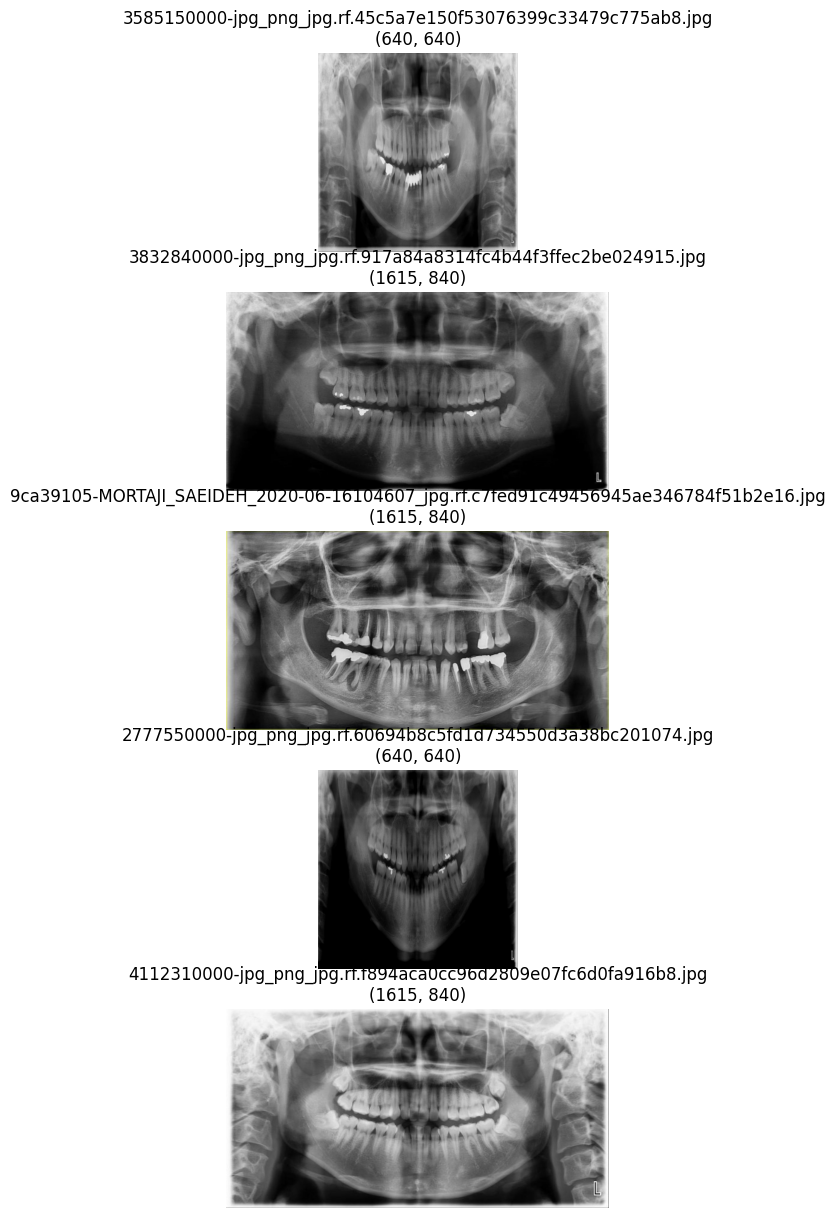

In [ ]:
plt.figure(figsize=(20, 15))
img = []

for i, img_file in enumerate(image_files):
    if (i >= 5):
        break

    print(i, img_file)
    img.append(Image.open(os.path.join(root, img_file)))
    numpy_array_pil = np.array(img[i])

    print("Image shape:", numpy_array_pil.shape)
    print("Image data type:", numpy_array_pil.dtype)
    print("Min pixel value:", numpy_array_pil.min())
    print("Max pixel value:", numpy_array_pil.max())

    plt.subplot(5, 1, i+1)
    plt.imshow(img[i], cmap='gray' if img[i].mode == 'L' else None)
    plt.title(f"{os.path.basename(img_file)}\n{img[i].size}")
    plt.axis('off')

In [ ]:
data = []

for i, img_file in enumerate(image_files):
    print(i, img_file)
    img = Image.open(os.path.join(root, img_file))

    print("Image shape:", numpy_array_pil.shape)
    print("Image data type:", numpy_array_pil.dtype)
    print("Min pixel value:", numpy_array_pil.min())
    print("Max pixel value:", numpy_array_pil.max())

    data.append(np.array(img))


0 /Users/syatsuzuka/.cache/kagglehub/datasets/lokisilvres/dental-disease-panoramic-detection-dataset/versions/6/COCO/COCO/train/3585150000-jpg_png_jpg.rf.45c5a7e150f53076399c33479c775ab8.jpg
Image shape: (840, 1615, 3)
Image data type: uint8
Min pixel value: 0
Max pixel value: 255
1 /Users/syatsuzuka/.cache/kagglehub/datasets/lokisilvres/dental-disease-panoramic-detection-dataset/versions/6/COCO/COCO/train/3832840000-jpg_png_jpg.rf.917a84a8314fc4b44f3ffec2be024915.jpg
Image shape: (840, 1615, 3)
Image data type: uint8
Min pixel value: 0
Max pixel value: 255
2 /Users/syatsuzuka/.cache/kagglehub/datasets/lokisilvres/dental-disease-panoramic-detection-dataset/versions/6/COCO/COCO/train/9ca39105-MORTAJI_SAEIDEH_2020-06-16104607_jpg.rf.c7fed91c49456945ae346784f51b2e16.jpg
Image shape: (840, 1615, 3)
Image data type: uint8
Min pixel value: 0
Max pixel value: 255
3 /Users/syatsuzuka/.cache/kagglehub/datasets/lokisilvres/dental-disease-panoramic-detection-dataset/versions/6/COCO/COCO/train/277

In [45]:
print(data[0])

[[[221 221 221]
  [216 216 216]
  [210 210 210]
  ...
  [245 245 245]
  [243 243 243]
  [192 192 192]]

 [[222 222 222]
  [217 217 217]
  [210 210 210]
  ...
  [246 246 246]
  [243 243 243]
  [192 192 192]]

 [[224 224 224]
  [219 219 219]
  [212 212 212]
  ...
  [247 247 247]
  [244 244 244]
  [192 192 192]]

 ...

 [[225 225 225]
  [222 222 222]
  [219 219 219]
  ...
  [244 244 244]
  [242 242 242]
  [192 192 192]]

 [[206 206 206]
  [203 203 203]
  [199 199 199]
  ...
  [222 222 222]
  [222 222 222]
  [175 175 175]]

 [[143 143 143]
  [140 140 140]
  [136 136 136]
  ...
  [153 153 153]
  [154 154 154]
  [108 108 108]]]
